# Sky localization including coherent analysis and priors

### Setup and imports

Import the relevant codes, set the plotting style

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib

from simple_pe.localization import loc, sky, event
from simple_pe.fstat import fstat
from simple_pe.detectors import detectors, network

import pylab
import logging

import lal

In [2]:
# set the plotting specs
pylab.rcParams.update({
    "lines.markersize": 6,
    "lines.markeredgewidth": 1.5,
    "lines.linewidth": 2.0,
    "font.size": 20,
    "axes.titlesize": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 20
})

Set the parameters

In [3]:
net_state = "design"
ntrials = int(1e5)
loc_methods = ["coh", "time"]
found_thresh = 5.0
net_thresh = 12.0
loc_thresh = 4.0
duty_cycle = 0.8
a_max = 50.  # maximum area we care about
a_step = 0.5  # step size
a_window = 2.5  # smoothing size
w = np.hanning(2 * a_window / a_step)

#logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

In [4]:
savefig = True
savetxt = False

## Generate the network

In [5]:
n = network.Network() #default is net_thresh=12
n.set_configuration(net_state, found_thresh, loc_thresh, duty_cycle)
ifolist = "".join(np.sort(n.ifos))

fname = "output/%s_%s_localization_output.txt" % (ifolist, net_state)
if savetxt: f = open(fname, "w")
else: f = sys.stdout

Record the details of the network

In [6]:
f.write("%s configuration\n" % net_state)
f.write("----------------------\n")
f.write("Detectors: %s\n" % ", ".join(n.ifos))
for ifo in n.ifos:
    i = getattr(n, ifo)
    f.write("\n")
    f.write("For %s\n" % ifo)
    f.write("------\n")
    for detail in ["det_range", "f_mean", "f_band", "duty_cycle"]:
        f.write("%s = %.2e\n" % (detail, getattr(i, detail)))


design configuration
----------------------
Detectors: H1, L1, V1

For H1
------
det_range = 1.98e+02
f_mean = 1.00e+02
f_band = 1.17e+02
duty_cycle = 8.00e-01

For L1
------
det_range = 1.98e+02
f_mean = 1.00e+02
f_band = 1.17e+02
duty_cycle = 8.00e-01

For V1
------
det_range = 1.28e+02
f_mean = 1.30e+02
f_band = 1.49e+02
duty_cycle = 8.00e-01


And locations/time delays between them

In [7]:
f.write("\nTime delays between detectors:\n")
for i1 in np.sort(n.ifos):
    for i2 in np.sort(n.ifos):
        if i1 < i2 and i1 != "H2":
            f.write("IFOS: %s, %s; Light travel time %.2f ms\n" %
                    (i1, i2, np.linalg.norm(getattr(n, i1).location -
                                         getattr(n, i2).location) /
                                         3e8 * 1000))


Time delays between detectors:
IFOS: H1, L1; Light travel time 10.01 ms
IFOS: H1, V1; Light travel time 27.27 ms
IFOS: L1, V1; Light travel time 26.43 ms


### Generate Events and calculate SNRs and localizations

First, calculate the maximum distance to which we want to simulate events

In [8]:
D_h = 2.26 * max(n.get_data("det_range"))
D_max = D_h * 8 / (net_thresh / np.sqrt(len(n.ifos)))

Generate events, determine if they are found and localized. 
  * Consider events found if they have network snr > net_thresh, 2 detectors above found_thresh.
  * Consider events localized if they are found and above loc_thresh in at least 3 detectors

Store localized events in localize_list, found (but not localized) events in found_list

In [9]:
num_found = 0
num_loc = 0

localize_list = []
found_list = []
full_list = []
for trial in range(ntrials):
    x = event.Event.random_values(D_max)
    x.add_network(n)
    full_list.append(x)
    if x.detected:
        num_found += 1
        if x.localized >= 3:
            num_loc += 1
            x.localize_all()
            localize_list.append(x)
        else:
            found_list.append(x)

/mnt/c/Users/spxsf2/Code/simple-pe/simple_pe/localization/loc.py:17: RuntimeWarning: invalid value encountered in sqrt
  sigma = 1 / np.sqrt(ev + epsilon)


Extract a few pieces of data that we want to use repeatedly

In [10]:
combined_area = {}
patches = {}

for loc in loc_methods:
    combined_area[loc] = np.array([x.area[loc] for x in localize_list])
    patches[loc] = np.array([x.patches[loc] for x in localize_list])

Now print the details

In [11]:
m = np.array([x.localization["marg"].method for x in localize_list])
c_frac = 1. * sum((m == "left") + (m == "right")) / num_loc
if len(n.ifos) == 3:
    mm = np.array([x.mirror_loc["marg"].method for x in localize_list])
    cm_frac = 1. * sum((mm == "left") + (mm == "right")) / num_loc

f.write("\nLocalization results:\n")
f.write("We have simulated %d events\n" % ntrials)
f.write("Assuming an independent duty cycle of %.1f for each detector\n"
        % duty_cycle)
f.write("%d were found (2 detectors SNR above %.1f, network above %1.f)\n"
    % (num_found, found_thresh, net_thresh))
f.write("%d were localized (3+ detectors SNR above %.1f)\n" % (num_loc, loc_thresh))
for method in loc_methods:
    f.write("---------------------\n")
    f.write("Localization by %s:" % method)
    f.write(" Median area %.1f deg^2\n" % np.median(combined_area[method]))
    f.write("2 patches for %d percent; 1 patch for %d percent of sources\n"
            % (100. * sum(patches[method] == 2) / len(patches[method]),
               100. * sum(patches[method] == 1) / len(patches[method])))
    if method == "marg":
        f.write("Percentage of sources circularly polarized: %d;" % (100 * c_frac))
        if len(n.ifos) == 3:
            f.write(" For mirror location: %d\n" % (100 * cm_frac))
        else:
            f.write("\n")
            
if savetxt:
    f.close()


Localization results:
We have simulated 100000 events
Assuming an independent duty cycle of 0.8 for each detector
4030 were found (2 detectors SNR above 5.0, network above 12)
1955 were localized (3+ detectors SNR above 4.0)
---------------------
Localization by coh: Median area 12.7 deg^2
2 patches for 59 percent; 1 patch for 40 percent of sources
---------------------
Localization by time: Median area 21.9 deg^2
2 patches for 100 percent; 1 patch for 0 percent of sources


## Plots

### Localization:

Set parameters for the histograms

In [12]:
bins = pylab.arange(0, a_max + 4 * a_window, a_step)
sky_ring = (a_max + 2 * a_window) * np.ones(len(found_list))
colors = {'time': 'b', 'coh': 'r', 'marg': 'k'}
labels = {'time':'Timing', 'coh':'Coherent', 'marg':'Astro priors', 3:'3 Detectors', 4:'4 Detectors', 5:'5 Detectors'}
sty = {'all': 'solid', 3:'dashed', 4: 'dashdot', 5:'dotted'}


Set up figure and make the plot:

In [13]:
areas = {}
for method in ["time", "coh", "marg"]:
    areas[method] = np.array([x.area[method] for x in localize_list])
    areas[method] = np.concatenate((areas[method], sky_ring))

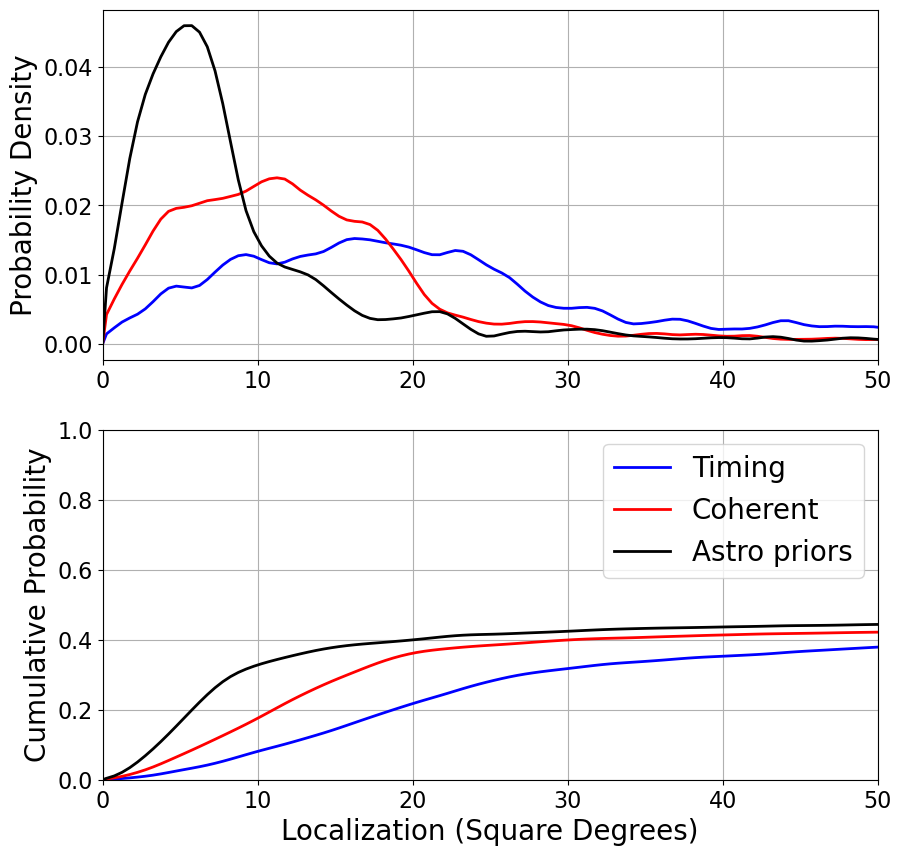

In [14]:
pylab.figure(figsize=(10,10))
pylab.subplot(211)
pylab.grid()
pylab.xlim([0, a_max])
pylab.ylabel("Probability Density")

pylab.subplot(212)
pylab.grid()
pylab.xlabel("Localization (Square Degrees)")
pylab.ylabel("Cumulative Probability")
pylab.xlim([0, a_max])
pylab.ylim([0,1])

for method in ["time", "coh", "marg"]:    
    # make histogram and smooth it
    h, b = np.histogram(np.minimum(areas[method], a_max + 2 * a_window), bins, density=True)
    y = np.convolve(w/w.sum(), h, 'same')
    b = 0.5*(b[:-1] + b[1:])
    y = np.insert(y[b <= (a_max + a_window)], 0, 0)
    b = np.insert(b[b <= (a_max + a_window)], 0, 0)

    # plot pdf
    pylab.subplot(211)
    pylab.plot(b, y,  
               color=colors[method], label=labels[method])

    # and cumulative
    pylab.subplot(212)
    pylab.plot(b, np.cumsum(y) * a_step,  
               color=colors[method], label=labels[method])
    #pylab.axhline(1.*num_loc/num_found)
    
    pylab.legend(loc='best')
    
if savefig: pylab.savefig("../figures/%s_%s_%s_localization_hist.png" %
                          (ifolist, net_state, method), 
                          dpi=200, bbox_inches='tight')

## Summary information

In [15]:
n_on = {}
n_on['found'] = []
for x in found_list + localize_list:
    n_on['found'].append( sum([hasattr(x, ifo) for ifo in n.ifos]) )
n_on['found'] = np.asarray(n_on['found'])

n_on['loc'] = []
for x in localize_list:
    n_on['loc'].append( sum([hasattr(x, ifo) for ifo in n.ifos]) )
n_on['loc'] = np.asarray(n_on['loc'])

In [16]:
n_loc = np.asarray([x.found for x in localize_list])

In [17]:
print("Simulated %d events" % ntrials)
print("Found %d events" % (len(found_list + localize_list)) )
for i in np.arange(2, len(n.ifos) + 1):
    print("Had %d detectors on for %d events" % (i, sum(n_on['found'] ==i)) )

print("-------------------")
print("Localized %d events" % len(localize_list))
for i in range(3, len(n.ifos) + 1):
    print("Had %d detectors on for %d localized events" % (i, sum(n_on['loc'] ==i)) )
print("-------------------")
for i in np.arange(3, len(n.ifos) + 1):
    print("Localized in %d detectors on for %d localized events" % (i, sum(n_loc ==i)) )

    
for method in ["time", "coh", "marg"]:
    print("-------------------")
    print("For %s localization" % method)
    for a in [1,5,20]:
        nf = sum(areas[method] < a)
        print("Found %d (%.1f%%) of sources within %d deg^2" % (nf, 
                                                                100. * nf / (len(found_list + localize_list)), a )  )
    

Simulated 100000 events
Found 4030 events
Had 2 detectors on for 1072 events
Had 3 detectors on for 2958 events
-------------------
Localized 1955 events
Had 3 detectors on for 1955 localized events
-------------------
Localized in 3 detectors on for 1496 localized events
-------------------
For time localization
Found 10 (0.2%) of sources within 1 deg^2
Found 112 (2.8%) of sources within 5 deg^2
Found 879 (21.8%) of sources within 20 deg^2
-------------------
For coh localization
Found 32 (0.8%) of sources within 1 deg^2
Found 285 (7.1%) of sources within 5 deg^2
Found 1467 (36.4%) of sources within 20 deg^2
-------------------
For marg localization
Found 51 (1.3%) of sources within 1 deg^2
Found 678 (16.8%) of sources within 5 deg^2
Found 1620 (40.2%) of sources within 20 deg^2


#### Area ratios

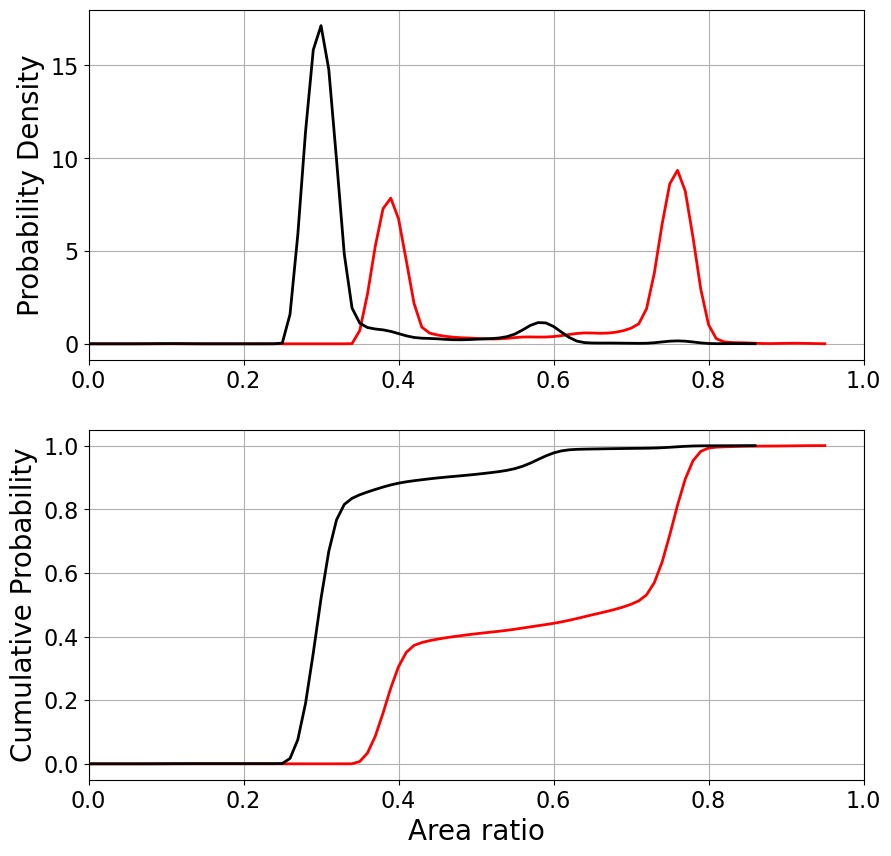

In [18]:
pylab.figure(figsize=(10,10))
pylab.subplot(211)
pylab.grid()
pylab.xlim(0,1)
pylab.ylabel("Probability Density")

pylab.subplot(212)
pylab.grid()
pylab.xlim(0,1)
pylab.xlabel("Area ratio")
pylab.ylabel("Cumulative Probability")

for method in ["coh", "marg"]:
    ratio = np.array([x.area[method]/x.area["time"] for x in localize_list])
    nifo = np.array([len(x.ifos) for x in localize_list])
    r_step = 0.01
    
    # make histogram and smooth it
    bins = pylab.arange(0, max(ratio) + 4*r_step, r_step)
    h, b = np.histogram(ratio, bins, density=True)    
    y = np.convolve(w/w.sum(), h, 'same')
    b_mid = 0.5*(b[:-1] + b[1:])  
    y = np.insert(y[b_mid <= (a_max + a_window)], 0, 0)

    if len(n.ifos) > 3:
        yn = {}
        for i in range(3, len(n.ifos)+1):
            h, b = np.histogram(ratio[nifo==i], bins, density=True)    
            yn[i] = np.convolve(w/w.sum(), h, 'same')
            yn[i] = np.insert(yn[i][b_mid <= (a_max + a_window)], 0, 0)

    b_mid = np.insert(b_mid[b_mid <= (a_max + a_window)], 0, 0)
    
    pylab.subplot(211)
    pylab.plot(b, y, color=colors[method],
               linestyle = sty['all'])
    if len(n.ifos) > 3:
        for i in range(3, len(n.ifos)+1):
            if method=='marg':
                pylab.plot(b, yn[i] * sum(nifo==i)/len(localize_list), 
                           color=colors[method], linestyle = sty[i], label=labels[i])
            else:
                pylab.plot(b, yn[i] * sum(nifo==i)/len(localize_list), 
                           color=colors[method], linestyle = sty[i])
                

    # and cumulative
    pylab.subplot(212)
    pylab.plot(b, r_step * np.cumsum(y), color=colors[method],
               linestyle = sty['all'])
    if len(n.ifos) > 3:
        for i in range(3, len(n.ifos)+1):
            if method=='marg':
                pylab.plot(b, r_step * np.cumsum(yn[i]) * sum(nifo==i)/ len(localize_list),
                           color=colors[method], 
                           linestyle = sty[i],
                           label=labels[i])
            else:
                pylab.plot(b, r_step * np.cumsum(yn[i]) * sum(nifo==i)/ len(localize_list),
                           color=colors[method], 
                           linestyle = sty[i])
        pylab.legend(loc='best')


if savefig: pylab.savefig("../figures/%s_%s_time_%s_localization_ratio.png" %
                              (ifolist, net_state, method),
                          dpi=200, bbox_inches='tight')

#### Sky Patches

The following is only relevant when there are three detectors

In [19]:
dsnrsq = {}
patches = {}
combined_area = {}
for loc in loc_methods:
    dsnrsq[loc] = np.array([(x.localization[loc].snr) ** 2 
                         - (x.mirror_loc[loc].snr) ** 2 
                         for x in localize_list if x.mirror])  
    patches[loc] = np.array([x.patches[loc] for x in localize_list if x.mirror])
    combined_area[loc] = np.array([x.area[loc] for x in localize_list if x.mirror])


Number of patches vs delta snrsq

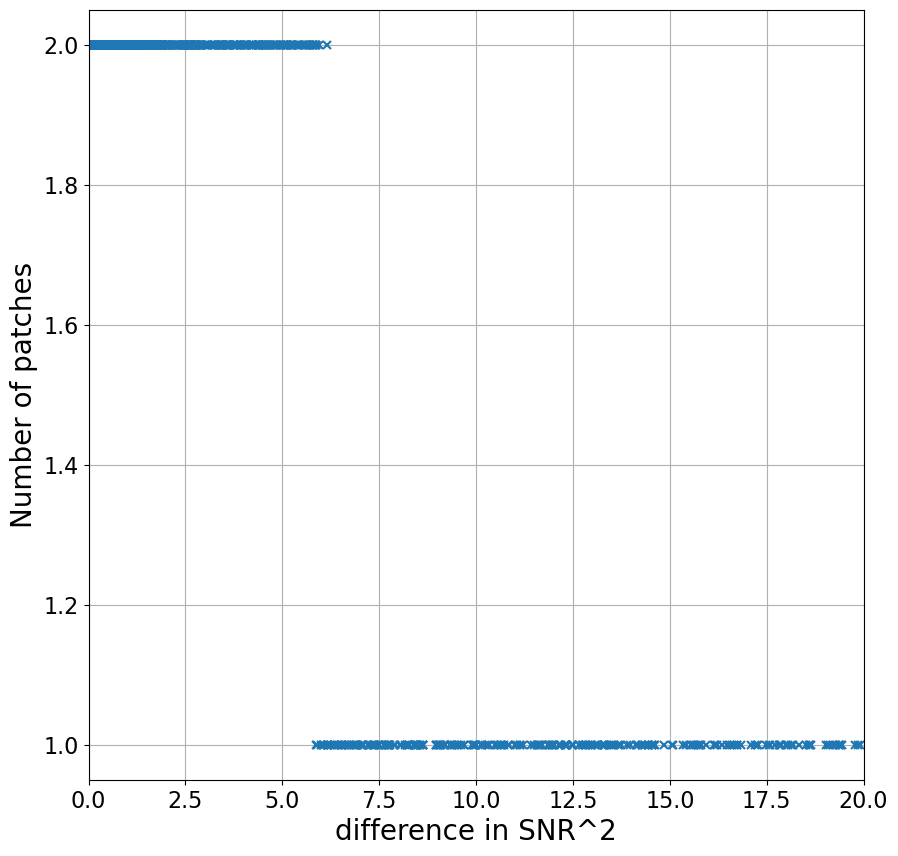

In [20]:
pylab.figure(figsize=(10,10))
pylab.plot(dsnrsq["coh"], patches["coh"], 'x')
pylab.xlim(0, 20)
pylab.xlabel("difference in SNR^2")
pylab.ylabel("Number of patches")
pylab.grid()
if savefig: pylab.savefig("../figures/%s_%s_localization_patches.png" % \
                              (ifolist, net_state), pad_inches=0)

#### Area increase vs delta snrsq

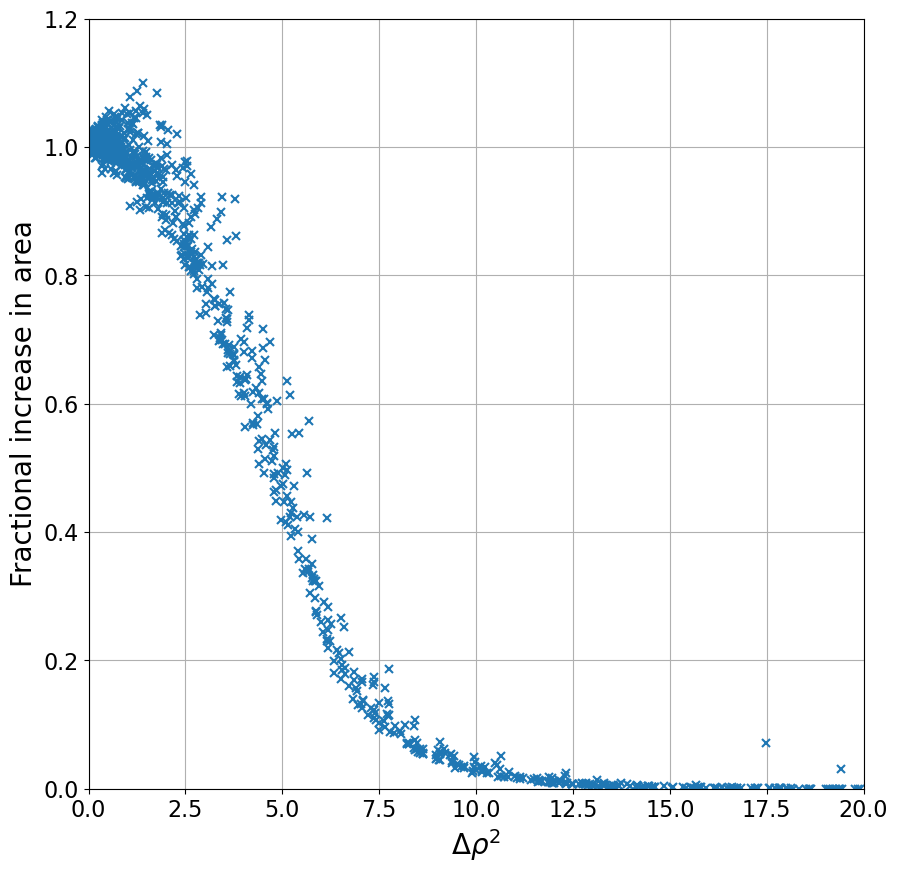

In [21]:
a = np.array([x.localization["coh"].area for x in localize_list if x.mirror])
pylab.figure(figsize=(10,10))
pylab.plot(dsnrsq["coh"], combined_area["coh"] / a - 1, 'x')
pylab.grid()
pylab.xlim(0, 20)
pylab.ylim(0, 1.2)
pylab.xlabel(r'$\Delta \rho^{2}$')
pylab.ylabel("Fractional increase in area")
if savefig: pylab.savefig("../figures/%s_%s_localization_mirror_contrib.png" % \
                        (ifolist, net_state), pad_inches=0)

#### Distance of mirror vs original

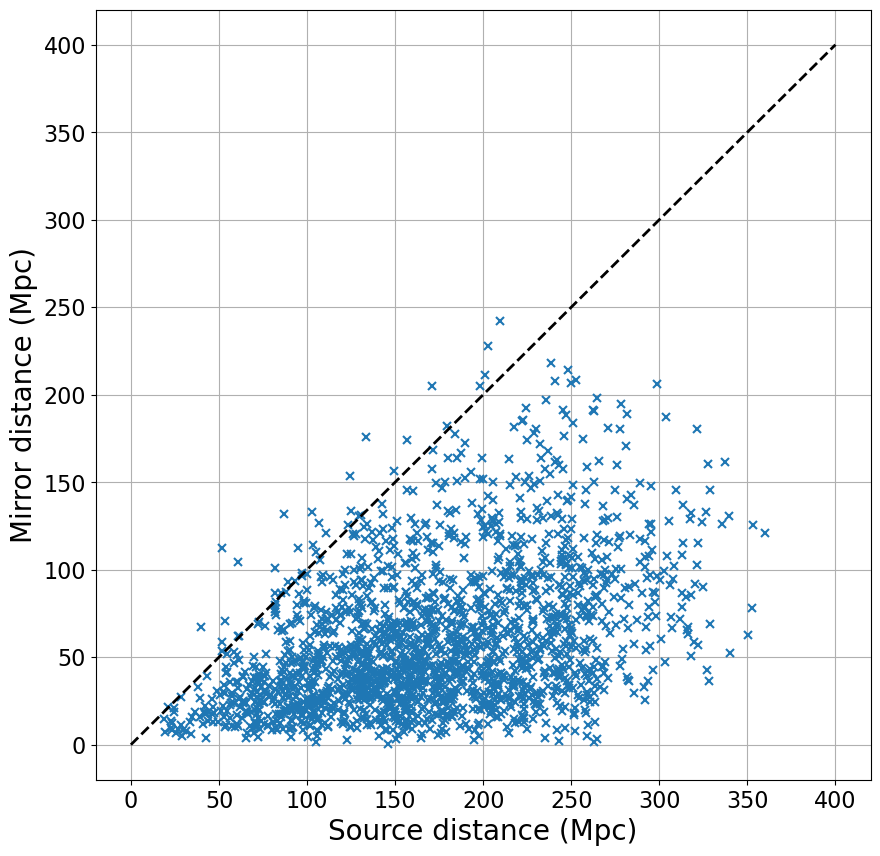

In [22]:
D = np.array([x.localization["coh"].D for x in localize_list if x.mirror])
Dm = np.array([x.mirror_loc["coh"].D for x in localize_list if x.mirror])
mir_ok = np.isfinite(Dm)

pylab.figure(figsize=(10,10))
pylab.plot(D[mir_ok], Dm[mir_ok], 'x')
x = np.linspace(0, np.ceil(D.max() / 50) * 50, 101)
pylab.plot(x, x, 'k--')
pylab.xlabel("Source distance (Mpc)")
pylab.ylabel("Mirror distance (Mpc)")
pylab.grid()
if savefig: pylab.savefig("../figures/%s_%s_localization_dist_vs_mirror.png" % \
                         (ifolist, net_state), pad_inches=0)

In [23]:
d_max = int(round(D.max() + 49.9, -2))
d_step = d_max/100.
d_window = d_max/20.
w = np.hanning(2 * d_window / d_step)

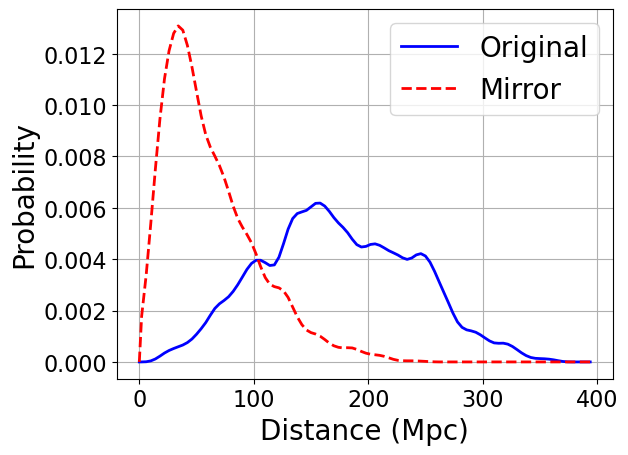

In [24]:
bins = pylab.arange(0, d_max, d_step)
h, b = np.histogram(D[mir_ok], bins, density=True)
y = np.convolve(w/w.sum(), h, 'same')
b = 0.5*(b[:-1] + b[1:])
y = np.insert(y[b <= (d_max + d_window)], 0, 0)
b =np. insert(b[b <= (d_max + d_window)], 0, 0)
pylab.plot(b, y, 'b', label="Original")

h, b = np.histogram(Dm[mir_ok], bins, density=True)
y = np.convolve(w/w.sum(), h, 'same')
b = 0.5*(b[:-1] + b[1:])
y = np.insert(y[b <= (d_max + d_window)], 0, 0)
b = np.insert(b[b <= (d_max + d_window)], 0, 0)
pylab.plot(b, y, 'r--', label="Mirror")

pylab.xlabel(r'Distance (Mpc)')
pylab.ylabel(r'Probability')
pylab.legend()
pylab.grid()
#if savefig: pylab.savefig("figures/%s_%s_localization_dist_distn.png" % \
#                          (ifolist, net_state), pad_inches=0)
    

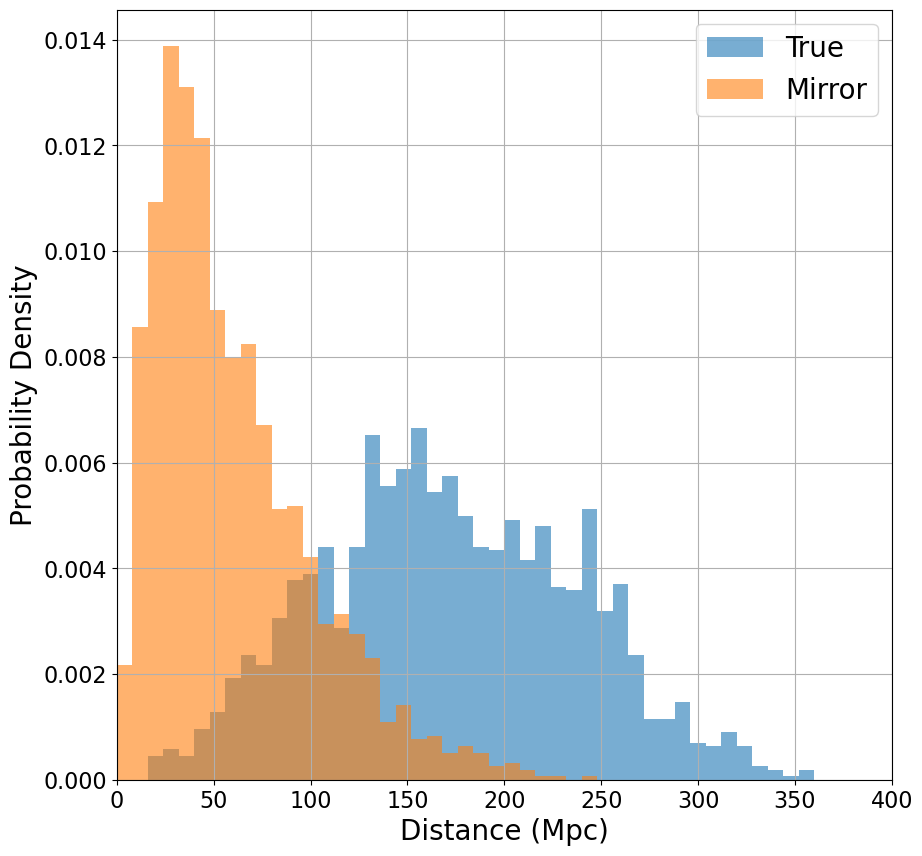

In [25]:
pylab.figure(figsize=(10,10))
bins = pylab.arange(0, d_max, 2*d_step)
pylab.hist(D[mir_ok], bins=bins, alpha=0.6, density=True, label='True')
pylab.hist(Dm[mir_ok], bins=bins, alpha=0.6, density=True, label='Mirror')

pylab.xlabel(r'Distance (Mpc)')
pylab.ylabel(r'Probability Density')
pylab.grid()
pylab.legend(loc='best')
pylab.xlim([0, d_max])
if savefig: pylab.savefig("../figures/%s_%s_localization_dist_distn.png" % \
                          (ifolist, net_state),
                          dpi=200, bbox_inches='tight')

#### Inclination of mirror vs original

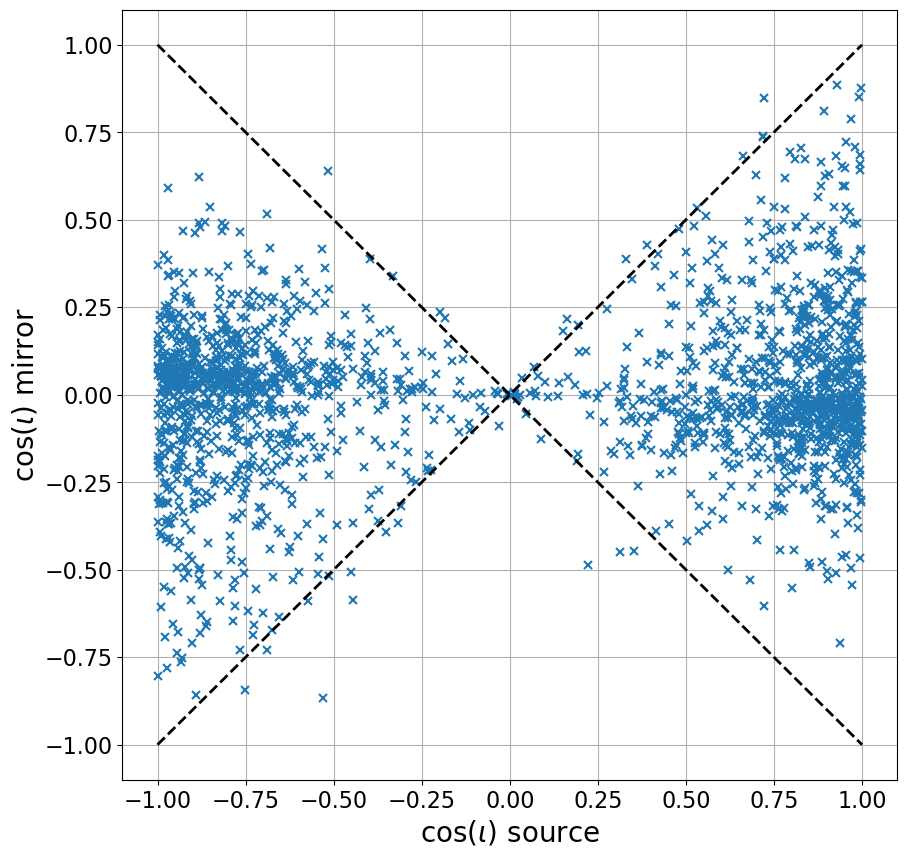

In [26]:
ci = np.array([x.localization["coh"].cosi for x in localize_list if x.mirror])
cim = np.array([x.mirror_loc["coh"].cosi for x in localize_list if x.mirror])

pylab.figure(figsize=(10,10))
pylab.plot(ci[mir_ok], cim[mir_ok], 'x')
x = np.linspace(-1, 1, 101)
pylab.plot(x, x, 'k--')
pylab.plot(x, -x, 'k--')
pylab.xlabel(r'$\cos(\iota)$ source')
pylab.ylabel(r'$\cos(\iota)$ mirror')
pylab.grid()
if savefig: pylab.savefig("../figures/%s_%s_localization_cosi_vs_mirror.png" % \
                          (ifolist, net_state), pad_inches=0)

In [27]:
i_max = 1.
i_min = -1 
i_step = 2./100.
i_window = 2./20.
w = np.hanning(2 * i_window / i_step)

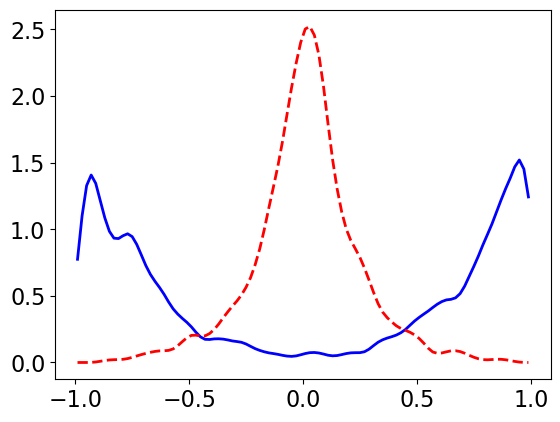

In [28]:
bins = pylab.arange(i_min, i_max+i_step, i_step)
h, b = np.histogram(ci[mir_ok], bins, density=True)
y = np.convolve(w/w.sum(), h, 'same')
b = 0.5*(b[:-1] + b[1:])
pylab.plot(b, y, 'b', label="Original")

bins = pylab.arange(i_min, i_max+i_step, i_step)
h, b = np.histogram(cim[mir_ok], bins, density=True)
y = np.convolve(w/w.sum(), h, 'same')
b = 0.5*(b[:-1] + b[1:])
pylab.plot(b, y, 'r--', label="Mirror")

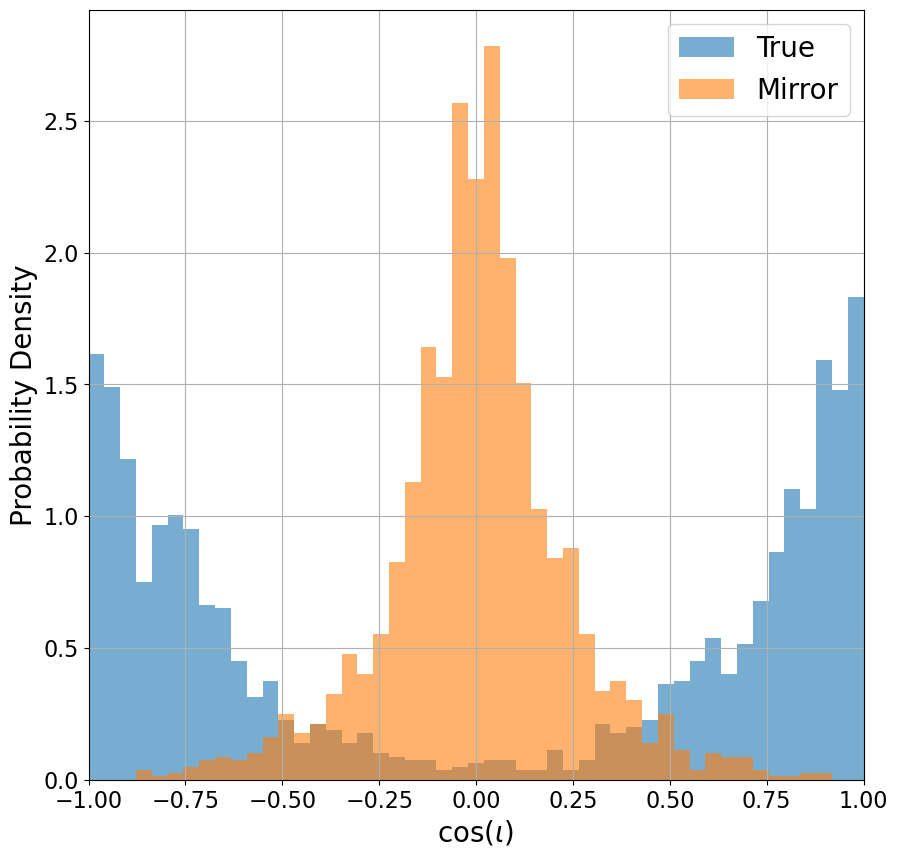

In [29]:
pylab.figure(figsize=(10,10))
pylab.hist(ci[mir_ok], bins=np.linspace(-1,1,50), alpha=0.6, density=True, label='True')
pylab.hist(cim[mir_ok], bins=np.linspace(-1,1,50), alpha=0.6, density=True, label='Mirror')

pylab.xlabel(r'$\cos(\iota)$')
pylab.ylabel(r'Probability Density')
pylab.grid()
pylab.legend(loc='best')
pylab.xlim([-1,1])
if savefig: pylab.savefig("../figures/%s_%s_localization_cosi_distn.png" % \
                          (ifolist, net_state), 
                          dpi=200, bbox_inches='tight')     

#### Phase diferences

In [30]:
dphi = np.array([fstat.phase_diff(fstat.params_to_a(x.D, x.cosi, 
                                                 x.psi, x.phi))
              for x in localize_list if x.mirror])

In [31]:
dphi_all = np.array([fstat.phase_diff(fstat.params_to_a(x.D, x.cosi, 
                                                 x.psi, x.phi))
              for x in full_list])
ci_all = np.array([x.cosi for x in full_list])

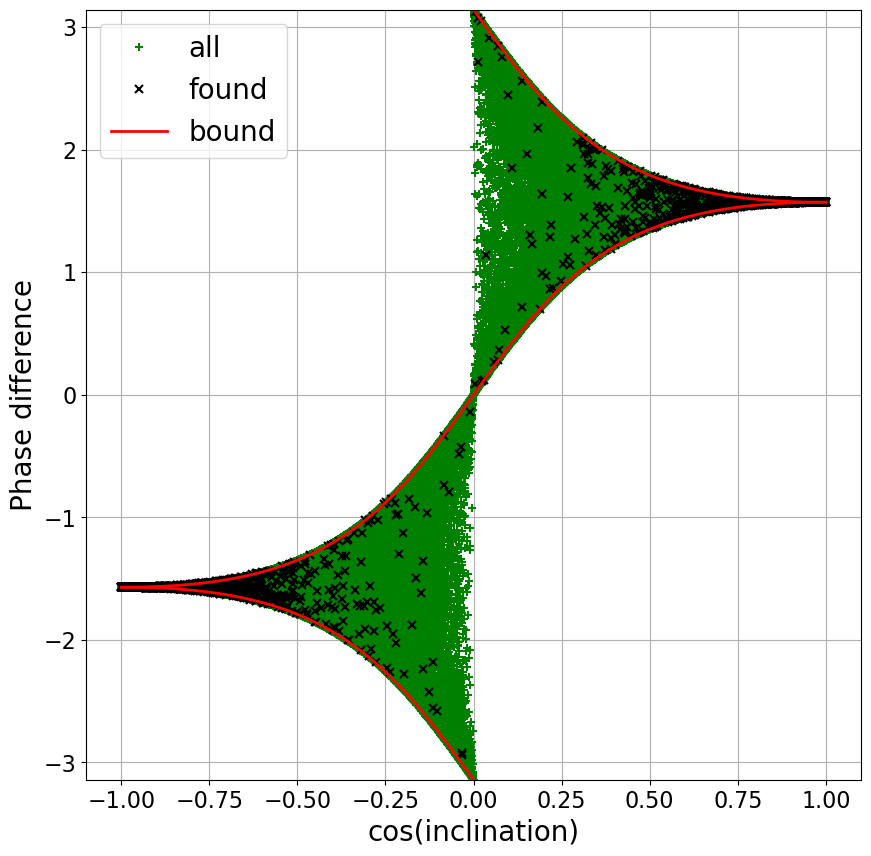

In [32]:
pylab.figure(figsize=(10,10))
pylab.plot(ci_all, dphi_all, 'g+', label='all')
pylab.plot(ci, dphi, 'kx', label='found')

x = np.linspace(-1,1,101)
pylab.plot(x, np.pi/2 - np.arctan2((1+x)**2 * (1-x)**2, 4*x*(1 + x**2)), 
           'r', label='bound')
pylab.plot(x, np.pi/2 + np.arctan2((1+x)**2 * (1-x)**2, 4*x*(1 + x**2)), 
           'r')
pylab.plot(x, -3*np.pi/2 + np.arctan2((1+x)**2 * (1-x)**2, 4*x*(1 + x**2)), 
           'r')
pylab.ylim(-np.pi, np.pi)
pylab.grid()
pylab.xlabel("cos(inclination)")
pylab.ylabel("Phase difference")
pylab.legend(loc='best')

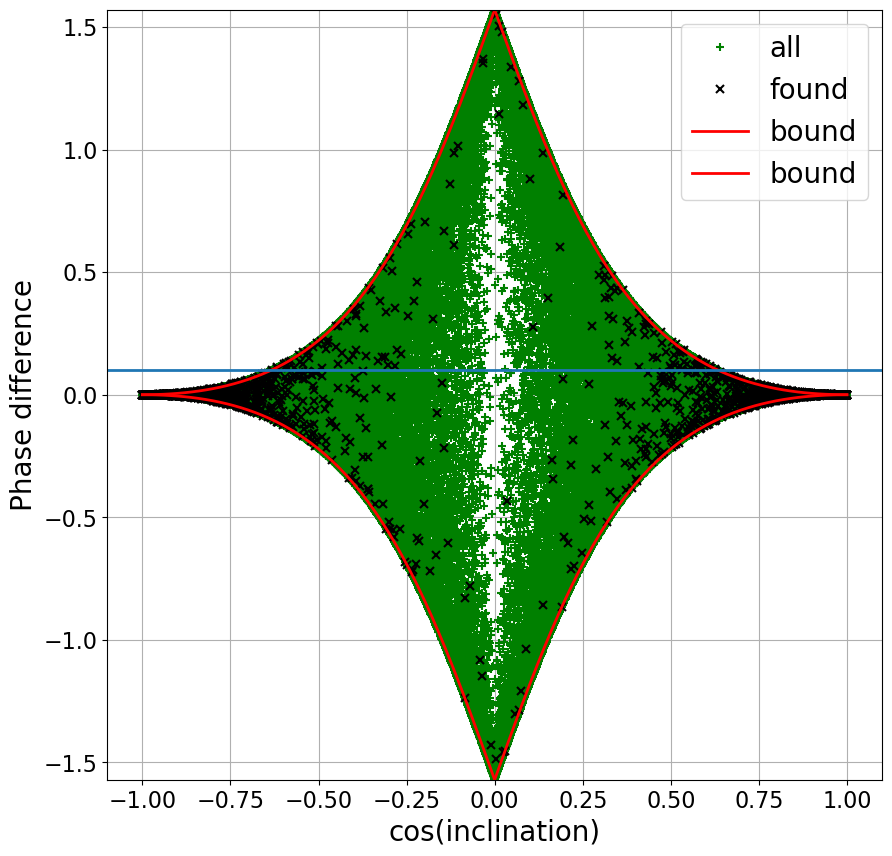

In [33]:
pylab.figure(figsize=(10,10))
pylab.plot(ci_all, abs(dphi_all) - np.pi/2, 'g+', label='all')
pylab.plot(ci, abs(dphi) - np.pi/2, 'kx', label='found')

x = np.linspace(-1,1,101)
pylab.plot(x, np.arctan2((1+x)**2 * (1-x)**2, 4*x*(1 + x**2)), 
           'r', label='bound')
pylab.plot(x, np.pi - np.arctan2((1+x)**2 * (1-x)**2, 4*x*(1 + x**2)), 
           'r')
pylab.plot(x, -np.arctan2((1+x)**2 * (1-x)**2, 4*x*(1 + x**2)), 
           'r', label='bound')
pylab.plot(x, -np.pi + np.arctan2((1+x)**2 * (1-x)**2, 4*x*(1 + x**2)), 
           'r')

pylab.ylim(-np.pi/2, np.pi/2)
pylab.grid()
pylab.axhline(0.1)
pylab.xlabel("cos(inclination)")
pylab.ylabel("Phase difference")
pylab.legend(loc='best')

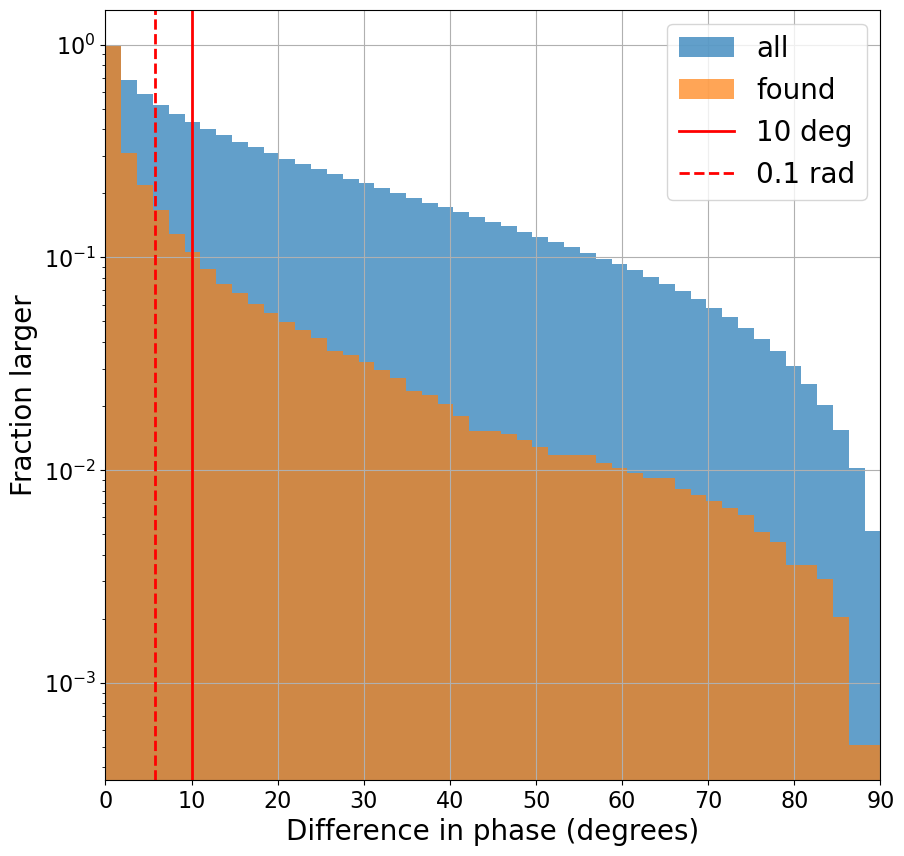

In [34]:
pylab.figure(figsize=(10,10))
pylab.hist(180./np.pi *abs(abs(dphi_all) - np.pi/2), bins=np.linspace(0,90,50),
  log=True, density=True, cumulative=-1, alpha=0.7, label='all')
pylab.hist(180./np.pi *abs(abs(dphi) - np.pi/2), bins=np.linspace(0,90,50),
  density=True, cumulative=-1, log=True, alpha=0.7, label='found')
pylab.grid()
pylab.xlim(0, 90)
pylab.xlabel("Difference in phase (degrees)")
pylab.ylabel("Fraction larger")
pylab.axvline(10.,color='r',label='10 deg')
pylab.axvline(np.degrees(0.1),color='r',linestyle='--',label='0.1 rad')
pylab.legend(loc='best')